# Linear regression of (estimated) fish age to selected log-ratios for gill samples
## What does this notebook do?
This produces a scatterplot with a line showing this regression. These scatterplots are in the Qurro paper as Figs. 1(d) and 2(d).

These plots, and the visualized linear regression, are only computed for gill samples: in particular, only gill samples that 1) are already used in the Qurro visualization and 2) have a valid log-ratio (i.e. do not have 0 in the numerator and/or denominator of the selected log-ratio).

## What's with the functions?
I've moved most of the logic here to three separate functions (`load_log_ratios()`, `make_scatterplot_of_log_ratios()`, and `perform_ols_regression_on_log_ratios()`) so that replicating this sort of thing with multiple log-ratio files should be relatively painless. All you need is the TSV file with sample plot data exported from Qurro (these are in this directory as `logratios.tsv` and `10_logratios.tsv` for the `Shewanella : Synechococcales` and `Top 10% : Bottom 10%` log-ratios, respectively).

The reason this notebook's functionality is spread across three different functions (and not just a single one) is so that the output of each step can be easily displayed (e.g. the `head()` of a DataFrame or a drawing of a plot), since putting `.head()` in the middle of a Jupyter Notebook cell doesn't actually display the head of the DataFrame. There's almost certainly a better way to structure this code, but I figure this should be a reasonable enough solution.

## Why do you write this documentation in a Q&A format? Seriously, reading this is weird.
Wow! That sounds like a loaded question, so I'm not going to answer it.

In [32]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

def load_log_ratios(tsv_filename):
    """Returns a DataFrame of sample plot data subset to gill samples with a valid log-ratio."""
    sp = pd.read_csv(tsv_filename, sep='\t', index_col=0, na_filter=False)
    print("{} samples total in the visualization.".format(len(sp.index)))
    
    # Remove samples with an invalid log-ratio
    sp_valid = sp.loc[sp["Current_Natural_Log_Ratio"] != "null"]
    print("{} samples in the visualization have a valid selected log-ratio.".format(
        len(sp_valid.index)
    ))
    
    # Remove samples that aren't from fish gills
    sp_valid_gill = sp_valid.loc[sp_valid["sample_type_body_site"] == "fish gill"]
    print("{} samples in the visualization with a valid selected log-ratio are gill samples.".format(
        len(sp_valid_gill.index)
    ))
    
    # We need to manually set the age and log-ratio columns as numeric for plotting them. Commenting these
    # lines out will cause things to break when plotting these values.
    # (Setting the columns of the DataFrame in this way results in pandas giving you a
    # SettingWithCopyWarning, but after a few minutes of messing around with this I haven't figured out a
    # way to get around that...)
    sp_valid_gill["age_2"] = pd.to_numeric(sp_valid_gill["age_2"])
    sp_valid_gill["Current_Natural_Log_Ratio"] = pd.to_numeric(sp_valid_gill["Current_Natural_Log_Ratio"])
    
    return sp_valid_gill

def make_scatterplot_of_log_ratios(sp_valid_gill):
    """Draws a basic scatter-plot of estimated age vs. log-ratio for just gill samples.
    
    Useful as a basic sanity check before we compute the linear regression.
    """
    
    # We use color and transparency values that match what's used in this scatterplot in Qurro
    # (this color is one of the defaults in the tableau10 colorscheme --
    # see https://vega.github.io/vega/docs/schemes/#tableau10)
    sp_valid_gill.plot(kind="scatter", x="age_2", y="Current_Natural_Log_Ratio", c="#e45756", alpha=0.7)
    
def perform_ols_regression_on_log_ratios(sp_valid_gill, output_figure_filename):
    """Draws a scatter-plot of estimated age vs. log-ratio, with a line showing a linear regression.
    
    The linear regression is computed using scikit-learn. Our use of LinearRegression here is based on
    this example: https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d.
    """
    # Reshape the data to get into a format that LinearRegression accepts
    x = sp_valid_gill["age_2"].values.reshape(-1, 1)
    y = sp_valid_gill["Current_Natural_Log_Ratio"].values.reshape(-1, 1)

    num_samples = len(sp_valid_gill.index)
    
    # Perform linear regression
    lr = LinearRegression().fit(x, y)
    lr_y = lr.predict(x)
    
    # Compute the R^2 value of this regression model
    r2 = lr.score(x, y)
    print("R^2 = {}".format(r2))

    # Plot the same scatterplot as before, but visualize the linear regression alongside the samples
    # NOTE: for some reason, I can't seem to get transparency here to remain when I export the final
    # Fig. 1 from LibreOffice Draw. So Fig. 1(d) will have opaque samples.
    sp_valid_gill.plot(kind="scatter", x="age_2", y="Current_Natural_Log_Ratio", c="#e45756", alpha=0.7)
    pyplot.plot(x, lr_y, color="black")

    # Make the titles informative (and large)
    pyplot.xlabel("Estimated fish age (age_2)", fontsize="x-large")
    pyplot.ylabel("Current Natural Log-Ratio", fontsize="x-large")
    # The double-backslashes in \\approx are needed in order to prevent the \a from being interpreted
    # as an escape character. Using a raw string (r"...") would also circumvent this problem; shout out
    # to https://stackoverflow.com/a/24739481/10730311 for help in getting around this.
    pyplot.title("Gill Samples with a Valid Log-Ratio ($n = {}$)\n$R^2 \\approx {:.4f}$".format(num_samples, r2), fontsize="x-large")

    # Make ticks consistent with Fig. 1(c) (which was edited in the Vega Editor)
    pyplot.yticks([-5, 0, 5])
    pyplot.xticks([0, 1, 2, 3, 4])

    # Also, show gridlines (like in Fig. 1(c))
    pyplot.grid(True)

    # Export the plot
    pyplot.savefig(output_figure_filename, dpi=600)

## Log-ratio of `Shewanella` to `Synechococcales`

In [33]:
df = load_log_ratios("logratios.tsv")
df.head()

639 samples total in the visualization.
285 samples in the visualization have a valid selected log-ratio.
143 samples in the visualization with a valid selected log-ratio are gill samples.


/home/marcus/Software/miniconda2/envs/skbio/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/marcus/Software/miniconda2/envs/skbio/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Current_Natural_Log_Ratio,age_2,sample_type_body_site
Sample ID,,,
11721.s38.19.gill,1.386294,1.822654,fish gill
11721.ep25ul.1000nl.s12.5.gill,1.342698,1.772148,fish gill
11721.s38.13.gill,6.555072,0.864577,fish gill
11721.s38.16.gill,6.540870,2.304387,fish gill
11721.echo5ul.200nl.s9.6.gill,6.877222,1.772148,fish gill


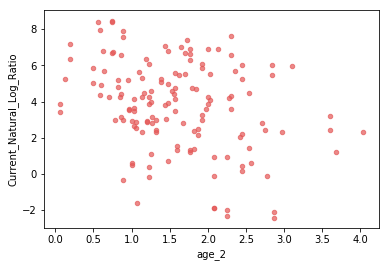

In [34]:
make_scatterplot_of_log_ratios(df)

R^2 = 0.10082600085558602


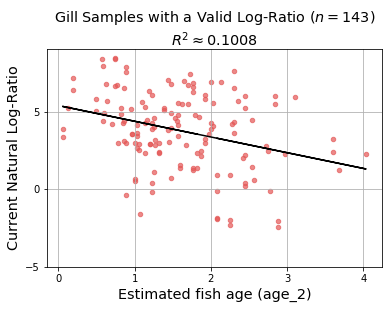

In [35]:
perform_ols_regression_on_log_ratios(df, "fig1d.pdf")

## Log-ratio of top 10% of features to bottom 10% of features for the gill differentials
It's actually the top ~9.95% of features, since the number of features in this dataset isn't divisible by 10. I hope you can forgive me ;)

Interestingly, although many more samples overall have a valid log-ratio for this log-ratio than the Shewanella:Synechococcales log-ratio (530 vs. 285), *less* gill samples have a valid log-ratio for this log-ratio (94 vs. 143).

In [36]:
df2 = load_log_ratios("10_logratios.tsv")
df2.head()

639 samples total in the visualization.
530 samples in the visualization have a valid selected log-ratio.
94 samples in the visualization with a valid selected log-ratio are gill samples.


/home/marcus/Software/miniconda2/envs/skbio/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/marcus/Software/miniconda2/envs/skbio/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Current_Natural_Log_Ratio,age_2,sample_type_body_site
Sample ID,,,
11721.s38.19.gill,4.698530,1.822654,fish gill
11721.ep25ul.1000nl.s12.5.gill,7.157541,1.772148,fish gill
11721.s38.13.gill,7.477180,0.864577,fish gill
11721.s38.16.gill,8.157657,2.304387,fish gill
11721.echo5ul.200nl.s8.6.gill,9.468194,0.823627,fish gill


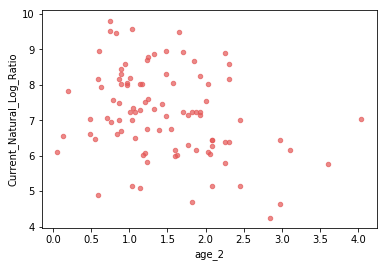

In [37]:
make_scatterplot_of_log_ratios(df2)

R^2 = 0.09275135863733142


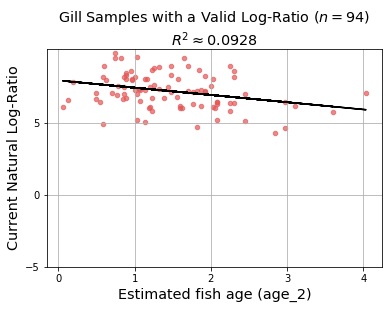

In [38]:
perform_ols_regression_on_log_ratios(df2, "fig2d.pdf")